Piyakorn Mona Munegan

Kaggle user name: Mona Munegan https://www.kaggle.com/piyakornmunegan

A code stub for accessing the dataset:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive

import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



In [2]:
drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgusted', 'fearful','happy', 'sad', 'surprised', 'neutral', 'OTHER']
dataset_directory = '/content/drive/My Drive/COMP8220/Project/data/'  ## CHANGE TO YOUR OWN DIRECTORY

Mounted at /content/drive/


# Data Exploration

In [3]:
images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_faces_only_data_images.npy'))

images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])   

print(images_train.shape)
print(labels_train.shape)
print(images_test_public.shape)
print(f'Dataset has {images_train.shape[1]*images_train.shape[2]} features')

(9328, 48, 48)
(9328,)
(1136, 48, 48)
Dataset has 2304 features


In [4]:
print(images_train.shape[0])

9328


In [5]:
sample = 1
print(images_train[sample])
print(labels_train[sample])
print(EMOTIONS[labels_train[sample]])

[[0.77647059 0.77647059 0.77647059 ... 0.78039216 0.78039216 0.78431373]
 [0.         0.         0.         ... 0.07843137 0.06666667 0.78039216]
 [0.00392157 0.         0.         ... 0.09019608 0.08627451 0.78039216]
 ...
 [0.         0.         0.         ... 0.1254902  0.10196078 0.78039216]
 [0.         0.         0.         ... 0.12156863 0.10196078 0.78039216]
 [0.         0.         0.         ... 0.11372549 0.10196078 0.78039216]]
6
neutral


## Training_data_images

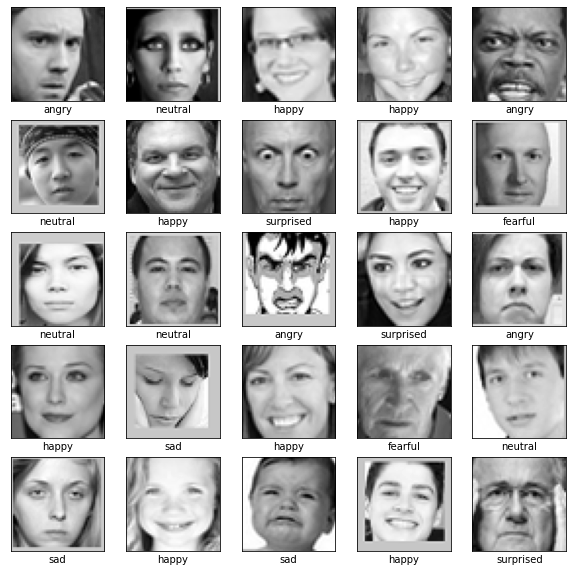

In [41]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

## PublicTest_faces_only_data_images

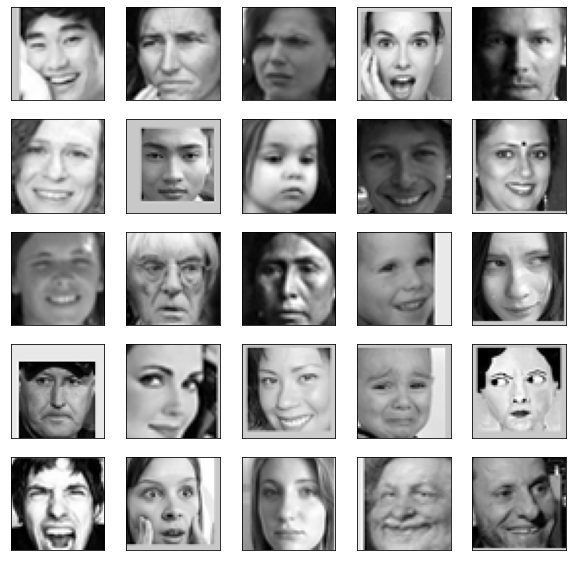

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_test_public[i], cmap='gray')
    #plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

## FER2013

In [23]:
filname = '/content/drive/My Drive/COMP8220/Project/data/fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('/content/drive/My Drive/COMP8220/Project/data/fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [24]:
#get data from csv function from #https://www.kaggle.com/code/shawon10/facial-expression-detection-cnn/notebook

def getData(filname):
    # images are 48x48
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [25]:
FER2013_images, FER2013_labels = getData(filname)
num_class = len(set(FER2013_labels))
print(num_class)

7


In [26]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 2304)
(35887,)


In [27]:
FER2013_images = FER2013_images.reshape([-1, image_size, image_size])
print(FER2013_images.shape)

(35887, 48, 48)


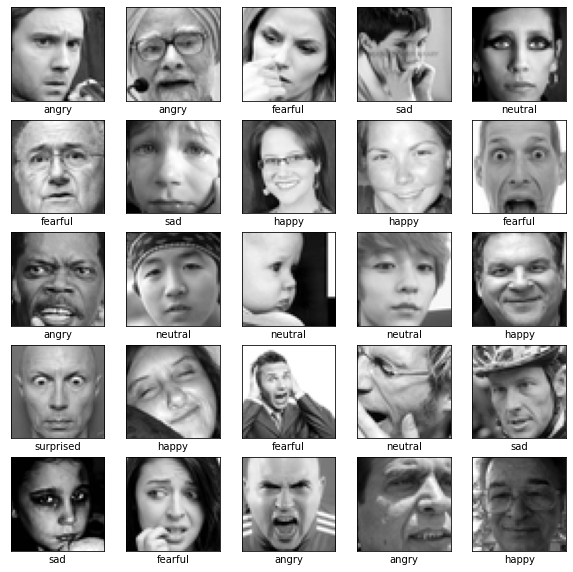

In [28]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(FER2013_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ FER2013_labels[i] ] )
plt.show()

In [9]:
#EMOTIONS dictionary
emotions = {0: 'angry', 1: 'disgusted', 2: 'fearful', 3: 'happy', 4: 'sad', 5: 'surprised', 6: 'neutral'}

## Histograms of Oriented Gradients (HOG)

https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/fer_without_ann.ipynb

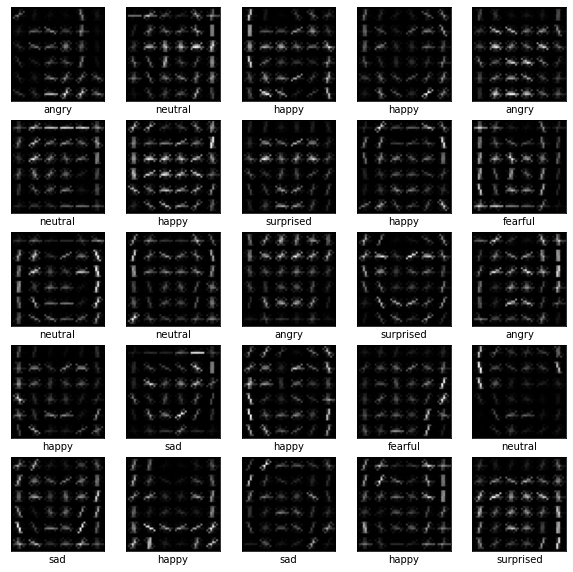

HOG feature vector con 900 features


In [6]:
#Hog image 
from skimage.feature import hog

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #Code for HOG image from https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/fer_without_ann.ipynb
    hog_feature_vector, hog_image = hog(images_train[i], 
                                    orientations=9, 
                                    pixels_per_cell=(8,8), 
                                    cells_per_block=(2,2),
                                    visualize=True, # True if you want the HOG image, default value is False
                                      )
    plt.imshow(hog_image, cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

print(f"HOG feature vector con {len(hog_feature_vector)} features")

# Data preparation

In [8]:
#Reshape X variables
X = images_train.reshape((images_train.shape[0], -1))
y = labels_train
print(X.shape)
print(y.shape)
print(X[1])

(9328, 2304)
(9328,)
[0.77647059 0.77647059 0.77647059 ... 0.11372549 0.10196078 0.78039216]


In [9]:
#Split dataset into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6529, 2304)
(2799, 2304)
(6529,)
(2799,)


### FER2013

In [30]:
#(n_samples, height, width, channels)
FER2013_images = FER2013_images.reshape((FER2013_images.shape[0], -1))

In [31]:
print(FER2013_images.shape)
print(FER2013_labels.shape)

(35887, 2304)
(35887,)


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(FER2013_images, FER2013_labels, test_size = 0.3, random_state=42)

In [33]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(25120, 2304)
(25120,)
(10767, 2304)
(10767,)


# Model bulding

## Logistic Regression

## Random Forest

In [ ]:
#Initail RandomForest model
start = time.time()
pipe = Pipeline(steps = [
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('RFC', RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 30.98900866508484
Accuracy: 0.3483386923901393


## SVC

In [ ]:
#Initail SVC model
start = time.time()
pipe = Pipeline(steps = [
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=0.1, gamma=100))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 25.55337929725647
Accuracy: 0.2958199356913183


## SVC + Tuning Parameters

In [ ]:
#SVC with RBF Kernel: Hyperparameters
#Setting hyperparameters
hyperparams = dict(svm__gamma=[0.001, 0.01, 0.1, 5], svm__C = [1, 10, 100, 1_000])

model = Pipeline(steps= [
    ('pca', PCA(n_components=0.9)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
    ])

#Cross Validation for GridSearchCV
#if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator= model, #model
    cv= CV, #cross Validation
    param_grid= hyperparams, #hyperparameters
    n_jobs=-1, #Use all available CPU cores
    verbose= 5 #Info
)
#Train across 5 folds, that's a total of (4*4)*5 = 80 rounds of training.
start = time.time()
grid_search.fit(X_train,y_train)
grid_search.best_params_, grid_search.best_score_
print("Time:", time.time()-start)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Time: 1616.1034724712372


In [ ]:
# Best params
gamma_ = grid_search.best_params_['svm__gamma']
C_ = grid_search.best_params_['svm__C']

In [ ]:
# Best params
grid_search.best_params_

{'svm__C': 10, 'svm__gamma': 0.01}

In [ ]:
# Best estimator
grid_search.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=0.9)), ('scaler', StandardScaler()),
                ('svm', SVC(C=10, gamma=0.01))])

In [ ]:
#Run model with the best params from GridSearchCV
start = time.time()
pipe = Pipeline(steps = [
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=C_, gamma=gamma_))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))
#Confusion Matrix
conf1 = confusion_matrix(y_test ,y_pred)
print(conf1)
report1 = classification_report(y_test ,y_pred)
print(report1)
#lable = ['0:angry', '1:disgusted', '2:fearful','3:happy', '4:sad', '5:surprised', '6:neutral']

Time: 26.7558171749115
Accuracy: 0.5501964987495535
[[154   0  27  55  35  23  75]
 [ 14  22   5   6   2   1   7]
 [ 50   0 130  62  26  23  54]
 [ 51   1  28 638  24  16  70]
 [ 48   0  25  48  97  13 100]
 [ 10   0  25  40   7 200  28]
 [ 50   1  51  97  45  16 299]]
              precision    recall  f1-score   support

           0       0.41      0.42      0.41       369
           1       0.92      0.39      0.54        57
           2       0.45      0.38      0.41       345
           3       0.67      0.77      0.72       828
           4       0.41      0.29      0.34       331
           5       0.68      0.65      0.66       310
           6       0.47      0.53      0.50       559

    accuracy                           0.55      2799
   macro avg       0.57      0.49      0.51      2799
weighted avg       0.55      0.55      0.54      2799



In [35]:
#Code for HOG Descriptor class https://github.com/isaacarroyov/fer_without_ann/blob/main/notebooks/OwnTransformers/ImageDescriptors.py

from sklearn.base import BaseEstimator, TransformerMixin

class DescriptorHOG(BaseEstimator, TransformerMixin):
    def __init__(self, hog_orientations = 9, hog_pixels_per_cell = (8,8), hog_cells_per_block=(2,2), hog_block_norm = 'L2', img_dim=(48,48)):
        self.hog_orientations = hog_orientations
        self.hog_pixels_per_cell = hog_pixels_per_cell
        self.hog_cells_per_block = hog_cells_per_block
        self.hog_block_norm = hog_block_norm
        self.img_dim = img_dim

    def fit(self, X, y=None):
        return self

    def feature_hog(self, arr):
        image = arr.reshape(self.img_dim)
        feature_vector = hog(image=image, orientations=self.hog_orientations,pixels_per_cell=self.hog_pixels_per_cell, 
                            cells_per_block=self.hog_cells_per_block, block_norm=self.hog_block_norm)
        return feature_vector

    def transform(self, X):
        X_hog = np.apply_along_axis(func1d=self.feature_hog, axis=1, arr=X)
        return X_hog

## SVC with RBF Kernel + Hog

In [ ]:
#SVC with RBF Kernel + Hog
#Setting hyperparameters
hyperparams = dict(svm__gamma=[0.001, 0.01, 0.1], svm__C = [1, 10, 100, 1_000])

model = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
    ])

#Cross Validation for GridSearchCV
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator= model, #model
    cv= CV, #cross Validation
    param_grid= hyperparams, #hyperparameters
    n_jobs=-1, #Use all CPU's
    verbose= 5 #Info
)
#Train across 5 folds, that's a total of (4*3)*5 = 60 rounds of training.
start = time.time()
grid_search.fit(X_train,y_train)
print("Time:", time.time()-start)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Time: 826.7381672859192


In [ ]:
# Best estimator
grid_search.best_estimator_


Pipeline(steps=[('hogdescriptor', DescriptorHOG()),
                ('pca', PCA(n_components=0.9)), ('scaler', StandardScaler()),
                ('svm', SVC(C=100, gamma=0.01))])

In [ ]:
#Run model with the best params from GridSearchCV
start = time.time()
gamma = 0.01
C = 100
pipe_hog = Pipeline(steps = [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=C, gamma=gamma))
    ])
pipe_hog.fit(X_train, y_train)
y_pred = pipe_hog.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

#Confusion Matrix
conf2 = confusion_matrix(y_test ,y_pred)
print(conf2)
report2 = classification_report(y_test ,y_pred)
print(report2)
#lable = ['0:angry', '1:disgusted', '2:fearful','3:happy', '4:sad', '5:surprised', '6:neutral']

Time: 25.16956663131714
Accuracy: 0.6037870668095748
[[180   0  16  45  15   8 105]
 [ 13  22   1   8   1   0  12]
 [ 43   0 121  53  18  18  92]
 [ 29   0   7 727   4  12  49]
 [ 60   0  17  49  76   2 127]
 [ 15   0  26  35   2 191  41]
 [ 28   0  12 110  22  14 373]]
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       369
           1       1.00      0.39      0.56        57
           2       0.60      0.35      0.44       345
           3       0.71      0.88      0.78       828
           4       0.55      0.23      0.32       331
           5       0.78      0.62      0.69       310
           6       0.47      0.67      0.55       559

    accuracy                           0.60      2799
   macro avg       0.66      0.52      0.55      2799
weighted avg       0.61      0.60      0.59      2799



## Random Forest + Hog

In [ ]:
#Initail RandomForest model
start = time.time()
pipe = Pipeline(steps = [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('RFC', RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1, random_state = 42))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 27.384280681610107
Accuracy: 0.3640585923544123


Tuning Parameters

In [ ]:
#RandomForestClassifier
#Setting hyperparameters
#hyperparams = dict(rfc__max_leaf_nodes=[20, 40, 80], rfc__n_estimators = [100, 200, 300, 500,1_000])

hyperparams = {
    'rfc__max_depth': [15, 20],
    'rfc__max_leaf_nodes': [100],
    'rfc__n_estimators': [1_000]
}

model = Pipeline(steps= [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.9)),
    ('scaler', StandardScaler()),
    ('rfc', RandomForestClassifier(random_state = 42))
    ])

#Cross Validation for GridSearchCV
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator= model, #model
    cv= CV, #cross Validation
    param_grid= hyperparams, #hyperparameters
    n_jobs=-1, #Use all CPU's
    verbose= 5 #Info
)
#Train across 5 folds, that's a total of (4*3)*5 = 60 rounds of training.
start = time.time()
grid_search.fit(X_train,y_train)
print("Time:", time.time()-start)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Time: 448.4223823547363


In [ ]:
#Check pipeline items
sorted(model.get_params().keys())

['hogdescriptor',
 'hogdescriptor__hog_block_norm',
 'hogdescriptor__hog_cells_per_block',
 'hogdescriptor__hog_orientations',
 'hogdescriptor__hog_pixels_per_cell',
 'hogdescriptor__img_dim',
 'memory',
 'pca',
 'pca__copy',
 'pca__iterated_power',
 'pca__n_components',
 'pca__random_state',
 'pca__svd_solver',
 'pca__tol',
 'pca__whiten',
 'rfc',
 'rfc__bootstrap',
 'rfc__ccp_alpha',
 'rfc__class_weight',
 'rfc__criterion',
 'rfc__max_depth',
 'rfc__max_features',
 'rfc__max_leaf_nodes',
 'rfc__max_samples',
 'rfc__min_impurity_decrease',
 'rfc__min_samples_leaf',
 'rfc__min_samples_split',
 'rfc__min_weight_fraction_leaf',
 'rfc__n_estimators',
 'rfc__n_jobs',
 'rfc__oob_score',
 'rfc__random_state',
 'rfc__verbose',
 'rfc__warm_start',
 'scaler',
 'scaler__copy',
 'scaler__with_mean',
 'scaler__with_std',
 'steps',
 'verbose']

In [ ]:
# Best params
max_depth_ = grid_search.best_params_['rfc__max_depth']
max_leaf_nodes_ = grid_search.best_params_['rfc__max_leaf_nodes']
n_estimators_ = grid_search.best_params_['rfc__n_estimators']

In [ ]:
# Best estimator
grid_search.best_estimator_


Pipeline(steps=[('hogdescriptor', DescriptorHOG()),
                ('pca', PCA(n_components=0.9)), ('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=15, max_leaf_nodes=100,
                                        n_estimators=1000, random_state=42))])

In [ ]:
#RandomForest model: Try Best estimator 
start = time.time()
pipe = Pipeline(steps = [
    ('hogdescriptor', DescriptorHOG()),
    ('pca', PCA(n_components=0.90)),
    ('scaler', StandardScaler()),
    ('RFC', RandomForestClassifier(random_state=42, max_depth=max_depth_,  max_leaf_nodes=max_leaf_nodes_,
                                  n_estimators=n_estimators_))
    ])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 66.79242873191833
Accuracy: 0.43051089674883886


## XGBoost

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier

In [11]:
#create XGBoost matrices
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

#set the parameters
xgb_parm = {'learning_rate' : 0.3,
         'max_depth' : 2,
         'colsample_bytree' : 1,
         'subsample' : 1,
         'min_child_weight' : 1,
         'gamma' : 0,
         'random_state' : 1502,
         'eval_metric' : 'auc', #rmse,
         'objective' : 'multi:softmax', 
         'num_class': 7}
#run XGBoost
xgb_model = xgb.XGBClassifier(params = xgb_parm, 
                  dtrain = Train, 
                  num_boost_round = 200, 
                  evals = [(Test, "Yes")],
                  verbose_eval =50)

In [12]:
start = time.time()
xgb_model.fit(X_train, y_train) 
y_pred = xgb_model.predict(X_test)
print("Time:", time.time()-start)
print("Accuracy:", accuracy_score(y_test, y_pred))

Time: 221.68280291557312
Accuracy: 0.5148267238299392


# Make predictions on Public test dataset

In [ ]:
images_test_public.shape[0] #1136

1136

In [ ]:
X_public = images_test_public.reshape((images_test_public.shape[0], -1))
print(X_public.shape)
X_public_pred = pipe_hog.predict(X_public)
X_public_pred

(1136, 2304)


array([3, 6, 3, ..., 3, 3, 3])

In [ ]:
id = []
for i in range(len(X_public_pred)):
  id.append(i)

public_pred = X_public_pred.tolist()
output = pd.DataFrame({'ID':id, 'Predictions':public_pred})

# Generate PUBLIC test csvs
output.to_csv(join(dataset_directory, '46318461_conv_predictions_SVM_HOG.csv'), index=False, header=True,  encoding='utf-8')

End here